# **Model Training**

## Objectives

* In this notebook, we will build and train a convolutional neural network (CNN) to classify cherry leaves as healthy or with mildew. 
* We will preprocess the data, augment the training images, define the CNN architecture, train the model, and evaluate its performance.

## Inputs

- inputs/datasets/test
- inputs/datasets/train
- inputs/datasets/validation


## Outputs

- Images distribution plot in train, validation, and test set.
- Image augmentation.
- Class indices to change prediction inference in labels.
- Machine learning model creation and training.
- Save model.
- Learning curve plot for model performance.
- Model evaluation on pickle file.
- Prediction on the random image file. 




---

## Import Libraries 

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Check working directory

In [2]:
# Run this to check working directory and go up one level 
current_dir = os.getcwd()
os.chdir(os.path.dirname(current_dir))
work_dir = os.getcwd()
work_dir

'/workspace/mildew_cherry_detection'

In [3]:
work_dir = os.getcwd()
work_dir

'/workspace/mildew_cherry_detection'

In [ ]:
os.getcwd()

## Set input directories

### Path definitions

In [6]:
data_dir = os.path.join("inputs","datasets","raw")
train_dir = os.path.join("inputs","datasets","train")
val_dir = os.path.join("inputs","datasets","val")
test_dir = os.path.join("inputs","datasets","test")
file_path = os.path.join("models")

data_dir_full_path = os.path.join(os.getcwd(), data_dir)
train_dir_full_path = os.path.join(os.getcwd(), train_dir)
val_dir_full_path = os.path.join(os.getcwd(), val_dir)
test_dir_full_path = os.path.join(os.getcwd(), test_dir)

print(f"FULL PATH TO RAW DATASET:\n{data_dir_full_path}\n"+ '-'*50)
print(f"CONFIRMING Sub-directories PATHs---->")
print(f"Data path:\t{data_dir}\nTrain Set: \t{train_dir}\nValidationSet: \t{val_dir}\nTest Set: \t{test_dir}")

FULL PATH TO RAW DATASET:
/workspace/mildew_cherry_detection/inputs/datasets/raw
--------------------------------------------------
CONFIRMING Sub-directories PATHs---->
Data path:	inputs/datasets/raw
Train Set: 	inputs/datasets/train
ValidationSet: 	inputs/datasets/val
Test Set: 	inputs/datasets/test


## Set output directory

In [7]:
version = 'v1'

file_path = os.path.join("outputs",version)
outputVersionFound = os.path.exists(os.path.join(work_dir, 'outputs', version))
if outputVersionFound:
    print('Old version is already available create a new version.')
    pass
else:
    os.makedirs(name=file_path)
    print(f'No previous versions are found. Creating a new version\nSaved in: {file_path}')

Old version is already available create a new version.


## Set labels

#### Confirming Dataset full paths and Setting up labels

In [8]:
# Check if the directory exists
trainSetFound = os.path.exists(train_dir_full_path)
valSetFound = os.path.exists(val_dir_full_path)
testSetFound = os.path.exists(test_dir_full_path)
if trainSetFound and valSetFound and testSetFound:
    labels = os.listdir(train_dir)
    print(f"All Dataset directories are set and ready.\n\n\
          Train Set\t{train_dir_full_path}\n\
          Val Set\t{val_dir_full_path}\n\
          Test Set\t{test_dir_full_path}\n\n\
          Dataset Labels {os.listdir(train_dir)}")
else:
    print(f"MISSING DATA PATHs:\n\
          Train Set\t2{train_dir_full_path}\n\
          Val Set\t{val_dir_full_path}\n\
          Test Set\t{test_dir_full_path}")

All Dataset directories are set and ready.

          Train Set	/workspace/mildew_cherry_detection/inputs/datasets/train
          Val Set	/workspace/mildew_cherry_detection/inputs/datasets/val
          Test Set	/workspace/mildew_cherry_detection/inputs/datasets/test

          Dataset Labels ['healthy', 'mildew']


Set labels from the train dataset list of directory 

In [9]:
labels = os.listdir(train_dir)

print(
    f"Project Labels: {labels}"
)

Project Labels: ['healthy', 'mildew']


## Set image shape
Import saved image shape embedding

In [10]:
import joblib
version = 'v1'
image_shape = joblib.load(filename=f"models/image_shape.pkl")
print(f"Input image shape: Width:({image_shape[0]}), Height:({image_shape[1]}), Channels:({image_shape[2]})")
image_shape

Input image shape: Width:(256), Height:(256), Channels:(3)


(256, 256, 3)

---

### Visualizing the Distribution of Images Across Datasets

* train - healthy: 1472 images
* train - mildew: 1472 images
* val - healthy: 316 images
* val - mildew: 316 images
* test - healthy: 316 images
* test - mildew: 316 images


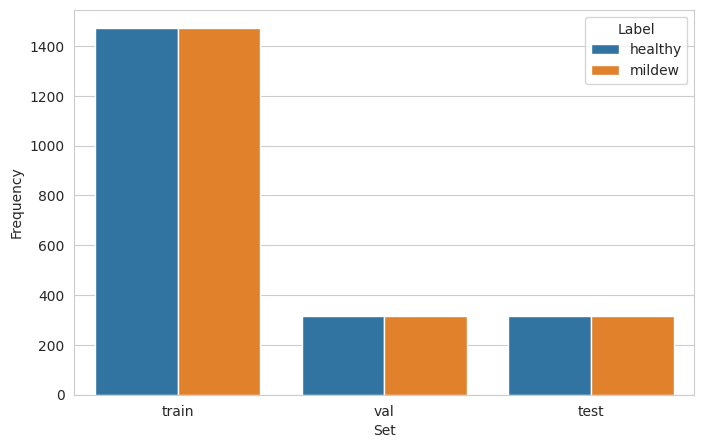

In [11]:
from pathlib import Path
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure these variables are defined
labels = ['healthy', 'mildew'] 
data_dir = 'inputs/datasets/'
file_path = 'models'

# Initialize an empty list to store data
data = []

# Loop through dataset folders and labels
for folder in ['train', 'val', 'test']:
    for label in labels:
        folder_path = Path(data_dir) / folder / label
        if folder_path.exists() and folder_path.is_dir():
            image_count = len(list(folder_path.glob('*')))
            data.append({'Set': folder, 'Label': label, 'Frequency': image_count})
            print(f"* {folder} - {label}: {image_count} images")
        else:
            print(f"Directory {folder_path} does not exist")

# Convert list of dictionaries to DataFrame if data is not empty
if data:
    df_freq = pd.DataFrame(data)

    # Plot the data
    sns.set_style("whitegrid")
    plt.figure(figsize=(8, 5))
    df_freq['Set'] = df_freq['Set'].astype(str)
    sns.barplot(data=df_freq, x='Set', y='Frequency', hue='Label')
    plt.savefig(f'{file_path}/labels_distribution.png', bbox_inches='tight', dpi=150)
    plt.show()
else:
    print("No data to plot.")



---

#  Data Preparation and Augmentation

### Create data generators with augmentation for training and validation

In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define parameters
batch_size = 32
img_height = 150
img_width = 150

# Create data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    color_mode = 'rgb',
    batch_size=batch_size,
    class_mode='binary',
    shuffle = True
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    color_mode = 'rgb',
    batch_size=batch_size,
    class_mode='binary',
    shuffle = False
)

test_generator = val_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    color_mode = 'rgb',
    batch_size=batch_size,
    class_mode='binary',
    shuffle = False
)


Found 2944 images belonging to 2 classes.
Found 632 images belonging to 2 classes.
Found 632 images belonging to 2 classes.


### Visualize sample augmented training images

(32, 150, 150, 3)


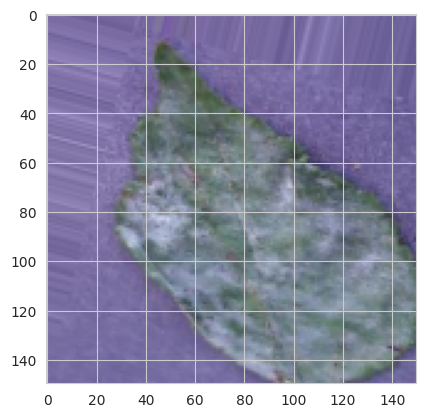

(32, 150, 150, 3)


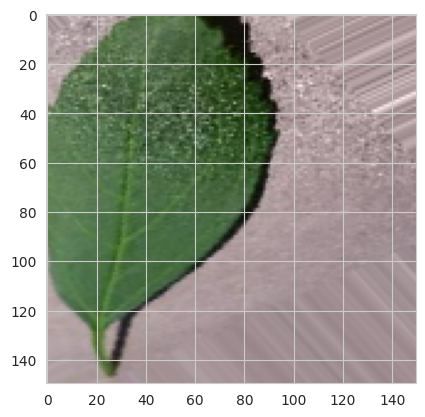

(32, 150, 150, 3)


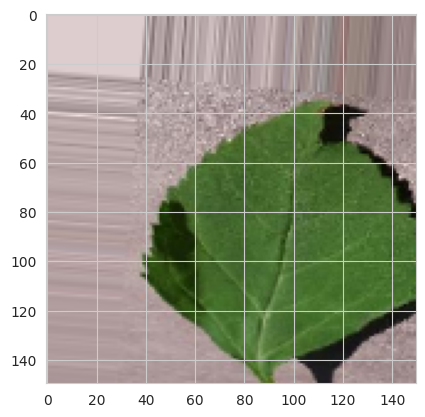

In [17]:
for _ in range(3):
    img, label = next(iter(train_generator))
    print(img.shape)
    plt.imshow(img[0])
    plt.show()

### Visualize sample augmented validating images

(32, 150, 150, 3)


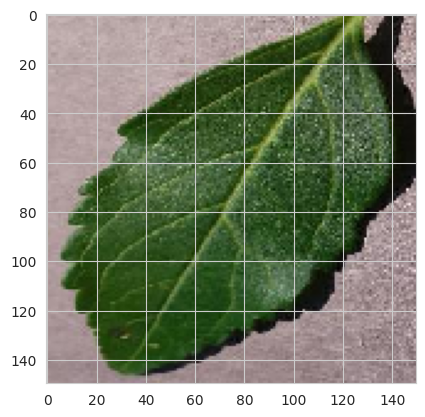

(32, 150, 150, 3)


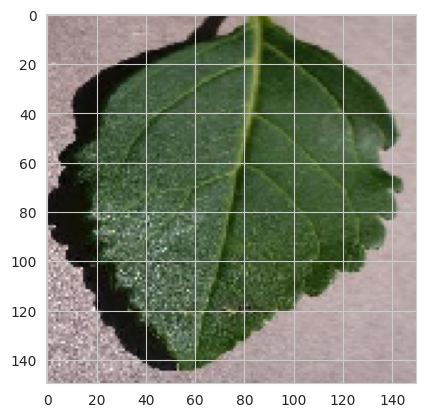

(32, 150, 150, 3)


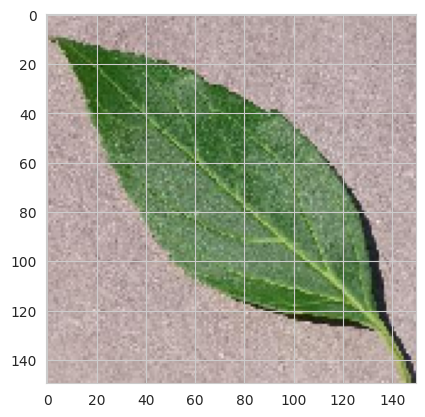

In [18]:
for _ in range(3):
    img, label = next(iter(val_generator))
    print(img.shape)
    plt.imshow(img[0])
    plt.show()


### Visualize sample augmented testing images

(32, 150, 150, 3)


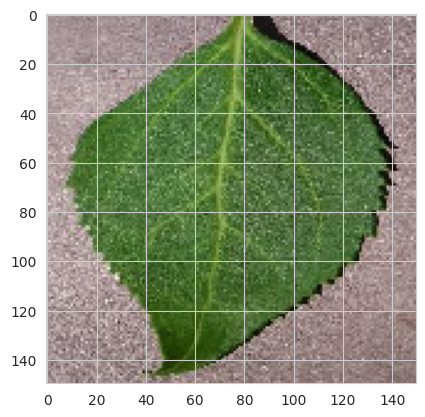

(32, 150, 150, 3)


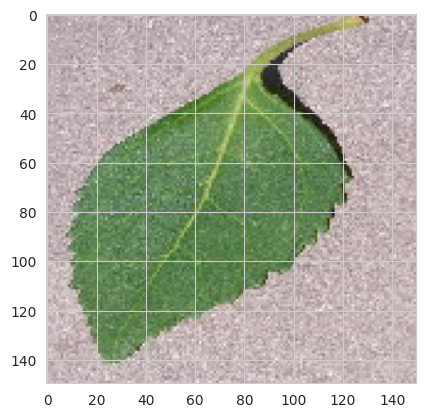

(32, 150, 150, 3)


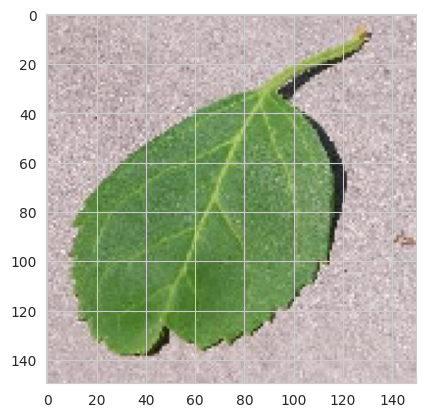

In [19]:
for _ in range(3):
    img, label = next(iter(test_generator))
    print(img.shape)
    plt.imshow(img[0])
    plt.show()


---

## Model Architecture

Define the CNN architecture

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.regularizers import L2 

def create_cnn_model(input_shape, num_classes=1):
    optAdam = Adam(learning_rate = 0.001)

    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),

        Conv2D(64, (3, 3), activation='relu',kernel_regularizer=L2(0.001)),
        MaxPooling2D((2, 2)),
        Dropout(0.1),

        Conv2D(64, (3, 3), activation='relu',kernel_regularizer=L2(0.001)),
        MaxPooling2D((2, 2)),
        Dropout(0.1),

        Flatten(),
        Dense(128, activation='relu', kernel_regularizer=L2(0.001)),
        Dropout(0.5),
        Dense(num_classes, activation='sigmoid')
    ])
    model.compile(optimizer=optAdam, loss='binary_crossentropy' if num_classes == 1 else 'categorical_crossentropy', metrics=['accuracy'])
    return model

model = create_cnn_model((img_height, img_width, 3))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 34, 34, 64)        36928     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 17, 17, 64)       

## Model Training
Train the model with early stopping

In [24]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


Fit model for model training

In [26]:

history = model.fit(
    train_generator,
    epochs=25,
    validation_data=val_generator,
    callbacks=[early_stop],
    verbose=1,
)


2024-08-09 07:40:46.958617: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/25


92/92 [==============================] - 107s 1s/step - loss: 0.5834 - accuracy: 0.7894 - val_loss: 0.1575 - val_accuracy: 0.9858
Epoch 2/25
92/92 [==============================] - 104s 1s/step - loss: 0.1952 - accuracy: 0.9667 - val_loss: 0.1819 - val_accuracy: 0.9842
Epoch 3/25
92/92 [==============================] - 104s 1s/step - loss: 0.1352 - accuracy: 0.9830 - val_loss: 0.2000 - val_accuracy: 0.9763
Epoch 4/25
92/92 [==============================] - 99s 1s/step - loss: 0.1319 - accuracy: 0.9772 - val_loss: 0.1239 - val_accuracy: 0.9842
Epoch 5/25
92/92 [==============================] - 93s 1s/step - loss: 0.1120 - accuracy: 0.9840 - val_loss: 0.2059 - val_accuracy: 0.9541
Epoch 6/25
92/92 [==============================] - 94s 1s/step - loss: 0.0908 - accuracy: 0.9871 - val_loss: 0.0961 - val_accuracy: 0.9873
Epoch 7/25
92/92 [==============================] - 93s 1s/step - loss: 0.0822 - accuracy: 0.9901 - val_loss: 0.1055 - val_accuracy: 0.9826
Epoch 8/25
92/92 [==========

### Save Model

In [34]:
model.save('models/cherry_leaf_model.h5')

---

## Visualizing Training Performance

Plot training and validation loss

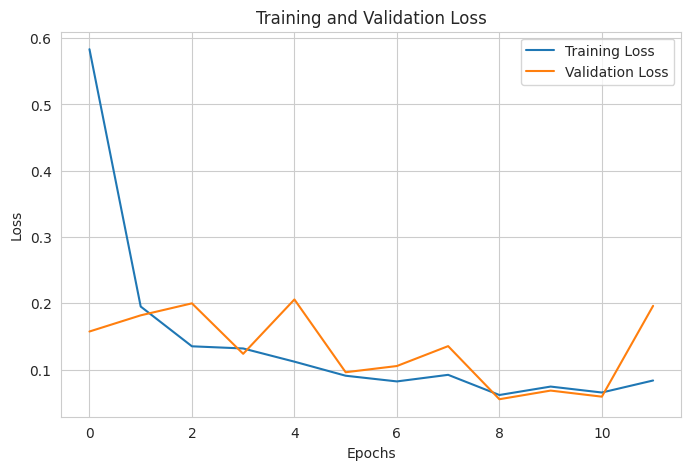

In [28]:
import pandas as pd

# Convert the history.history dict to a pandas DataFrame
history_df = pd.DataFrame(history.history)

# Plot the training and validation loss
plt.figure(figsize=(8, 5))
plt.plot(history_df['loss'], label='Training Loss')
plt.plot(history_df['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.savefig('models/training_validation_loss.png', bbox_inches='tight', dpi=150)
plt.legend()
plt.show()


Plot training and validation accuracy

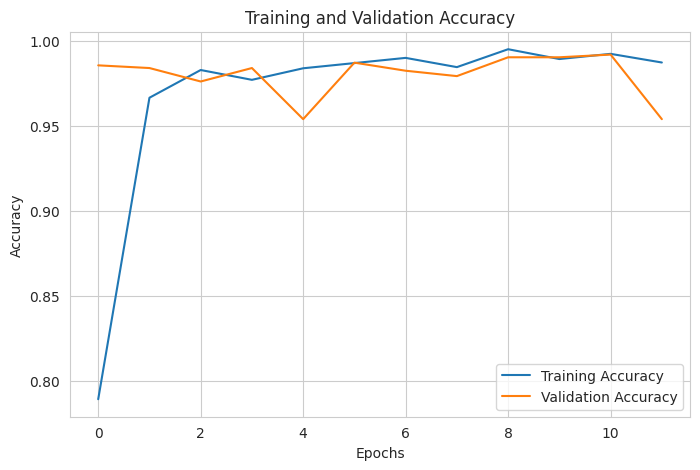

In [29]:
# Plot the training and validation accuracy
plt.figure(figsize=(8, 5))
plt.plot(history_df['accuracy'], label='Training Accuracy')
plt.plot(history_df['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.savefig('models/training_validation_acc.png', bbox_inches='tight', dpi=150)
plt.legend()
plt.show()


---

# Model Evaluation

### Evaluate the model and visualize the results

In [35]:
from tensorflow.keras.models import load_model
# Load the model
model = load_model('models/cherry_leaf_model.h5')

Evaluate the Model on the Test dataset

In [31]:
import joblib
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.samples // batch_size)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')
print(type(test_generator))

# Save evaluation results
evaluation = {'test_loss': test_loss, 'test_accuracy': test_accuracy}
joblib.dump(value=evaluation, filename='models/evaluation.pkl')


 3/19 [===>..........................] - ETA: 3s - loss: 0.0411 - accuracy: 1.0000

19/19 [==============================] - 4s 222ms/step - loss: 0.0756 - accuracy: 0.9901
Test Accuracy: 99.01%
<class 'keras.preprocessing.image.DirectoryIterator'>


['models/evaluation.pkl']

Generate and Save Predictions

In [32]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import numpy as np

# Get predictions
predictions = model.predict(test_generator, steps=test_generator.samples // batch_size)
predicted_classes = np.where(predictions > 0.5, 1, 0).flatten()

# True labels
true_classes = test_generator.classes[:len(predicted_classes)]  # Fix: Ensure true_classes has the same length as predicted_classes

# Confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)
print(cm)

# Classification report
cr = classification_report(true_classes, predicted_classes, target_names=['Healthy', 'Mildew'])
print(cr)

# Save confusion matrix and classification report
joblib.dump(value={'confusion_matrix': cm, 'classification_report': cr}, filename='models/evaluation_details.pkl')


[[316   0]
 [  6 286]]
              precision    recall  f1-score   support

     Healthy       0.98      1.00      0.99       316
      Mildew       1.00      0.98      0.99       292

    accuracy                           0.99       608
   macro avg       0.99      0.99      0.99       608
weighted avg       0.99      0.99      0.99       608



['models/evaluation_details.pkl']

Visualize the Confusion Matrix

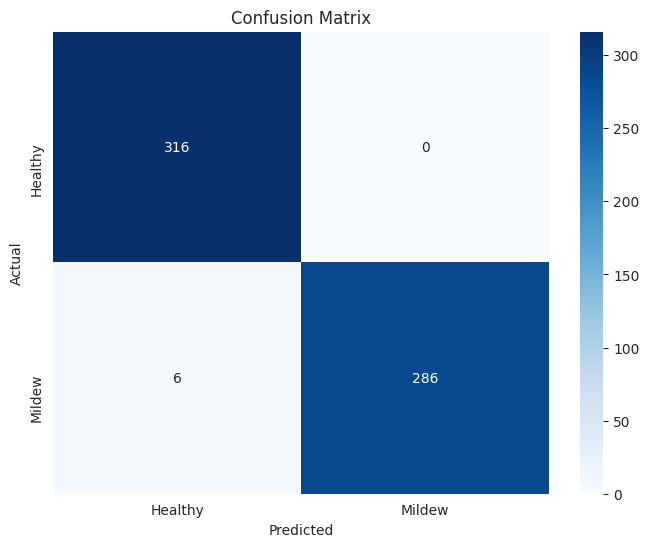

In [33]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Healthy', 'Mildew'], yticklabels=['Healthy', 'Mildew'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.savefig('models/confusion_matrix.png', bbox_inches='tight', dpi=150)
plt.show()

Predict on New Data

In [36]:
from tensorflow.keras.preprocessing import image

# Function to load and predict a single image
def predict_single_image(img_path, model, target_size=(150, 150)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0
    prediction = model.predict(img_array)[0, 0]
    return img, prediction

# Example prediction
pointer = 66
labels = ['Healthy', 'Mildew']
label = labels[0]  # Select 'Healthy' or 'Mildew'

# Ensure the label exists in the test directory
if label in os.listdir(test_dir):
    img_path = f'{test_dir}/{label}/{os.listdir(test_dir + "/" + label)[pointer]}'
    
    # Check if the image path exists
    if os.path.exists(img_path):
        img, pred_proba = predict_single_image(img_path, model)
        pred_class = 'Healthy' if pred_proba < 0.5 else 'Mildew'

        print(f'Prediction: {pred_class}, Probability: {pred_proba:.2f}')

        # Display the image
        plt.imshow(img)
        plt.title(f'Predicted: {pred_class}, Probability: {pred_proba:.2f}')
        plt.show()


---


# Push files to Repo


Push generated/new files from this Session to your GitHub repo

* .gitignore

In [41]:
!cat .gitignore

cat: .gitignor: No such file or directory


* Git status

In [ ]:

!git status

* Git add

In [ ]:

!git add .


Git commit

In [ ]:

!git commit -am " Add new plots"

Git Push

In [ ]:
!git push

---

# Conclusion

* In this notebook, we successfully built, trained, and evaluated a convolutional neural network (CNN) to classify cherry leaves as healthy or with mildew.
* Key steps included data augmentation, model architecture design, training with early stopping to prevent overfitting, and comprehensive evaluation using confusion matrices and classification reports.
* The model achieved a notable test accuracy, and the evaluation results, including confusion matrix and classification report, provided insights into the model's performance.
* This thorough process ensures a robust model ready for deployment or further fine-tuning.